In [1]:
import numpy as np
import trimesh
import pyrender
import matplotlib.pyplot as plt
import os

os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["LIBGL_ALWAYS_SOFTWARE"] = "1"

SHOW_Y_AXIS = True

In [2]:
# --- Custom LookAt Matrix Function ---
def look_at_matrix(eye, target, up):
    """
    Create a camera pose matrix (camera-to-world) for PyRender
    """
    f = target - eye
    f = f / np.linalg.norm(f) # Forward vector (from eye to target)

    # If the forward vector is parallel to the up vector, adjust the up vector
    # to avoid numerical instability in the cross product.
    if np.isclose(np.linalg.norm(np.cross(f, up)), 0):
        # Pick a new 'up' vector that is not parallel to 'f'
        if np.isclose(np.abs(np.dot(f, np.array([0, 1, 0]))), 1):
            up = np.array([0, 0, 1]) # If f is vertical, use Z as up
        else:
            up = np.array([0, 1, 0]) # Otherwise, use Y as up

    s = np.cross(f, up)
    s = s / np.linalg.norm(s) # Right vector

    u = np.cross(s, f)
    u = u / np.linalg.norm(u) # Corrected Up vector

    # Construct the view matrix (world-to-camera)
    view_matrix = np.array([
        [s[0], s[1], s[2], -np.dot(s, eye)],
        [u[0], u[1], u[2], -np.dot(u, eye)],
        [-f[0], -f[1], -f[2], np.dot(f, eye)],  # Camera looks down -Z axis
        [0, 0, 0, 1]
    ])

    # PyRender expects a pose matrix (camera-to-world), so we invert the view matrix
    camera_pose = np.linalg.inv(view_matrix)
    
    return camera_pose

# Load the mesh
lod_3_mesh = trimesh.load("/home/jeans/win/aaaJAIST/resources/LOD_data_50/1/lod3.obj")
# lod_3_mesh.apply_translation(-lod_3_mesh.centroid)
# scene = pyrender.Scene.from_trimesh_scene(lod_3_mesh)

bbox_center = (lod_3_mesh.bounds[0] + lod_3_mesh.bounds[1]) / 2

# Print for comparison
print(f"Original centroid: {lod_3_mesh.centroid}")
print(f"Bounding box center: {bbox_center}")

# Translate mesh to center it at the bounding box center (not centroid)
lod_3_mesh.apply_translation(-bbox_center)

# Verify the translation worked
print(f"New centroid after translation: {lod_3_mesh.centroid}")
print(f"New bounding box center: {(lod_3_mesh.bounds[0] + lod_3_mesh.bounds[1]) / 2}")

scene = pyrender.Scene.from_trimesh_scene(lod_3_mesh)

Original centroid: [ 738.969      14.630361 -377.992   ]
Bounding box center: [ 738.969      14.630361 -377.992   ]
New centroid after translation: [-5.68434189e-14  8.88178420e-16 -2.84217094e-14]
New bounding box center: [-5.68434189e-14  8.88178420e-16 -2.84217094e-14]


Mesh bounds: [212.886     28.310478  93.954   ]
Mesh center: [-5.68434189e-14  8.88178420e-16 -2.84217094e-14]
Radius: 106.44300000000004


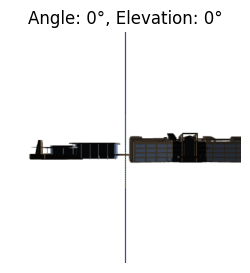

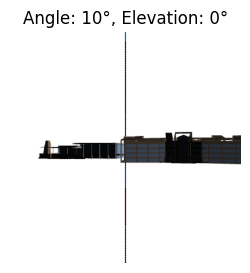

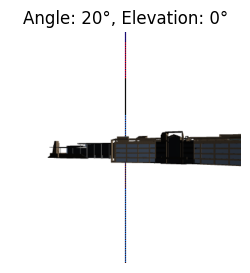

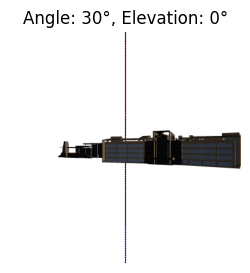

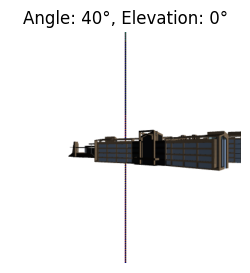

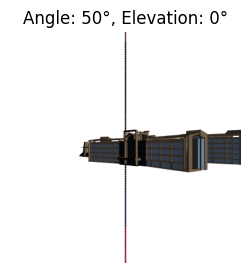

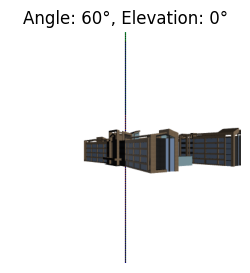

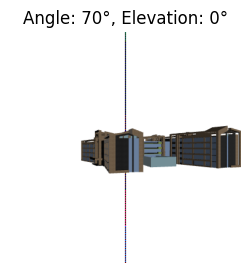

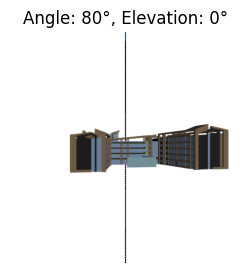

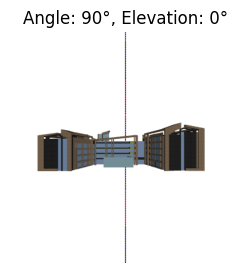

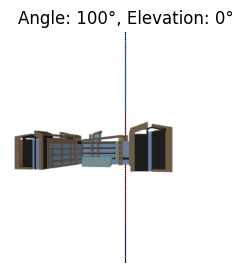

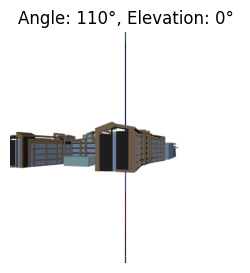

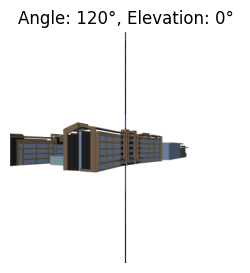

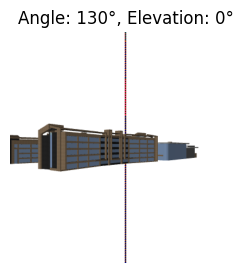

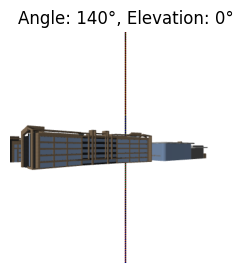

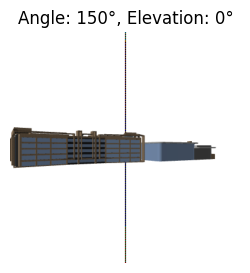

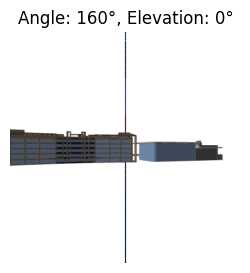

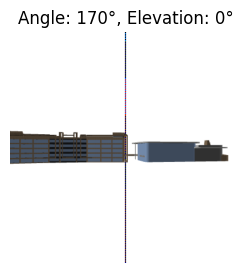

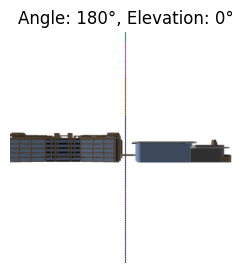

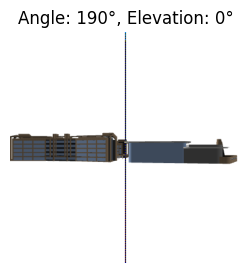

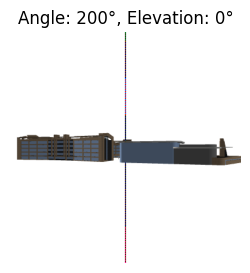

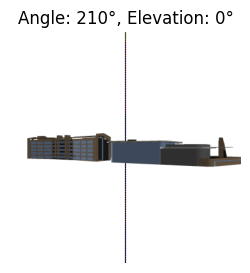

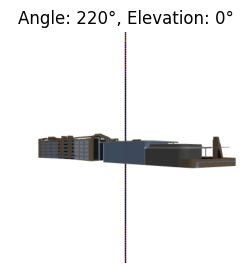

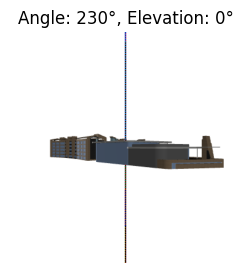

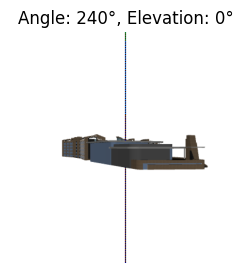

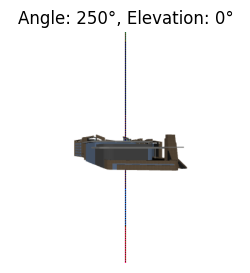

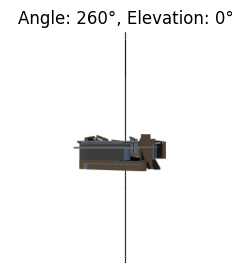

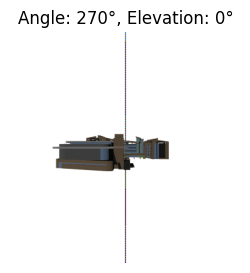

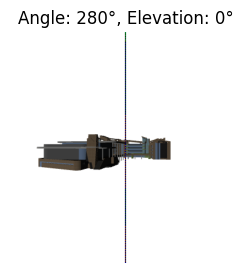

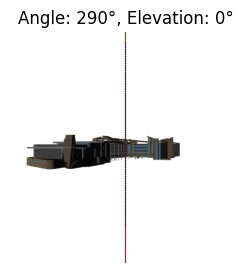

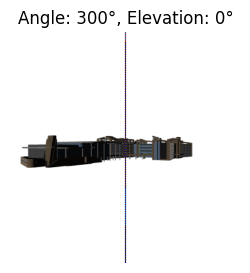

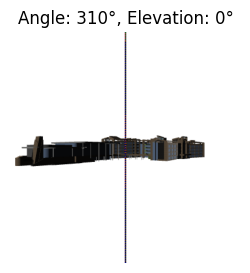

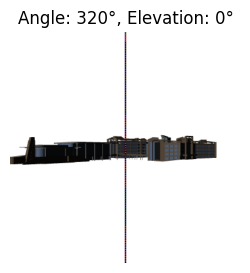

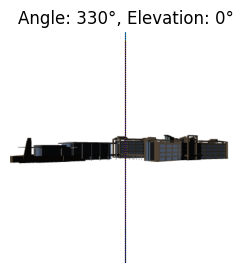

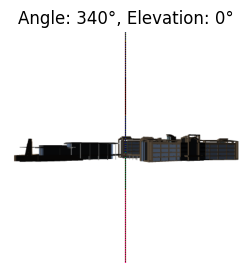

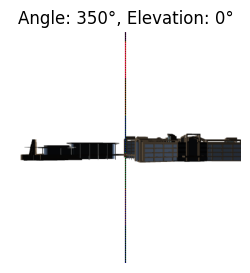

In [3]:
# Calculate bounding box for camera positioning
bounds = lod_3_mesh.extents
center = lod_3_mesh.centroid # This will now be [0,0,0] because we centered the mesh
radius = np.max(bounds) /2

print(f"Mesh bounds: {bounds}")
print(f"Mesh center: {center}")
print(f"Radius: {radius}")
    
# Setup Pyrender scene and renderer
scene = pyrender.Scene.from_trimesh_scene(lod_3_mesh) # Add the main mesh
r = pyrender.OffscreenRenderer(400, 400)

if SHOW_Y_AXIS:
    bbox_mesh = trimesh.primitives.Box(extents=[1,100000,1])
    bbox_material = pyrender.Material(wireframe=True)
    bbox_pyrender_mesh = pyrender.Mesh.from_trimesh(bbox_mesh, material=bbox_material)
    scene.add(bbox_pyrender_mesh)
    
    
# Raymond lighting (as in your original code)
intensity = 3.0

key = pyrender.DirectionalLight(color=np.ones(3), intensity=intensity)
key_pose = np.array([
    [ 0,  0,  1,  2],
    [ 0,  1,  0,  2],
    [ 1,  0,  0,  2],
    [ 0,  0,  0,  1],
])
scene.add(key, pose=key_pose)

fill = pyrender.DirectionalLight(color=np.ones(3), intensity=intensity * 0.5)
fill_pose = np.array([
    [ 0,  0, -1, -2],
    [ 0,  1,  0,  1],
    [-1,  0,  0, -2],
    [ 0,  0,  0,  1],
])
scene.add(fill, pose=fill_pose)

back = pyrender.DirectionalLight(color=np.ones(3), intensity=intensity * 0.3)
back_pose = np.array([
    [ 1,  0,  0, -2],
    [ 0,  0,  1, -2],
    [ 0,  1,  0,  2],
    [ 0,  0,  0,  1],
])
scene.add(back, pose=back_pose)
# --- Camera Setup and Rendering Loop ---
camera_distance_factor = 2.0
camera_node = None

# Test with just a few angles first to debug
for camera_angle_deg in range(0, 360, 10):  # Changed to 45 degree steps for testing
    for camera_elevation_deg in range(0, 19, 20): # This loop will only run for elevation=0
        camera_angle_rad = np.deg2rad(camera_angle_deg)
        camera_elevation_rad = np.deg2rad(camera_elevation_deg)

        # Calculate camera position in spherical coordinates
        x = radius * camera_distance_factor * np.cos(camera_elevation_rad) * np.sin(camera_angle_rad)
        y = radius * camera_distance_factor * np.sin(camera_elevation_rad)
        z = radius * camera_distance_factor * np.cos(camera_elevation_rad) * np.cos(camera_angle_rad)

        eye = np.array([x, y, z])  # Camera position
        target = np.array([0.0, 0.0, 0.0])  # Look at origin (where we centered the mesh)
        up = np.array([0.0, 1.0, 0.0])  # World up vector

        # print(f"Camera angle: {camera_angle_deg}°, elevation: {camera_elevation_deg}°")
        # print(f"Eye position: {eye}")
        # print(f"Target position: {target}")
        # print(f"Distance from eye to target: {np.linalg.norm(eye - target)}")

        camera_pose = look_at_matrix(eye, target, up)
        # print(f"Camera pose matrix:\n{camera_pose}")

        camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
        
        if camera_node is not None:
            scene.remove_node(camera_node)
        
        camera_node = scene.add(camera, pose=camera_pose)

        color, _ = r.render(scene)

        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(color)
        plt.title(f'Angle: {camera_angle_deg}°, Elevation: {camera_elevation_deg}°')
        plt.show()
# # --- Elliptical Camera Orbit Setup ---
# # Extract mesh dimensions
# width = bounds[0]   # X dimension
# height = bounds[1]  # Y dimension  
# depth = bounds[2]   # Z dimension

# print(f"Mesh dimensions - Width: {width:.2f}, Height: {height:.2f}, Depth: {depth:.2f}")

# # Create ellipse based on width and depth (ignoring height for horizontal orbit)
# # Use the larger dimension as the major axis
# if width >= depth:
#     # Wide building: ellipse stretched along X-axis
#     semi_major_axis = width / 2
#     semi_minor_axis = depth / 2
#     major_axis_is_x = True
# else:
#     # Long building: ellipse stretched along Z-axis  
#     semi_major_axis = depth / 2
#     semi_minor_axis = width / 2
#     major_axis_is_x = False

# camera_distance_factor = 2.5  # Adjust this for overall distance
# camera_node = None

# print(f"Ellipse setup - Major axis: {semi_major_axis:.2f}, Minor axis: {semi_minor_axis:.2f}")
# print(f"Major axis along {'X' if major_axis_is_x else 'Z'}-axis")

# # Test with just a few angles first to debug
# for camera_angle_deg in range(0, 360, 10):
#     for camera_elevation_deg in range(0, 19, 20):  # This loop will only run for elevation=0
#         camera_angle_rad = np.deg2rad(camera_angle_deg)
#         camera_elevation_rad = np.deg2rad(camera_elevation_deg)

#         # CORRECTED: Calculate elliptical orbit position
#         if major_axis_is_x:
#             # Ellipse along X-axis: x uses major axis (width), z uses minor axis (depth)
#             x_orbit = semi_major_axis * np.cos(camera_angle_rad)  # Width controls X
#             z_orbit = semi_minor_axis * np.sin(camera_angle_rad)  # Depth controls Z
#         else:
#             # Ellipse along Z-axis: x uses minor axis (width), z uses major axis (depth)
#             x_orbit = semi_minor_axis * np.cos(camera_angle_rad)  # Width controls X
#             z_orbit = semi_major_axis * np.sin(camera_angle_rad)  # Depth controls Z

#         # Apply distance factor and elevation
#         x = x_orbit * camera_distance_factor
#         y = height/2 * camera_distance_factor * np.sin(camera_elevation_rad)  # Use height for Y positioning
#         z = z_orbit * camera_distance_factor

#         # Calculate distance from center for this angle
#         orbit_radius = np.sqrt(x_orbit**2 + z_orbit**2)
        
#         eye = np.array([x, y, z])  # Camera position
#         target = np.array([0.0, 0.0, 0.0])  # Look at origin (where we centered the mesh)
#         up = np.array([0.0, 1.0, 0.0])  # World up vector

#         print(f"Angle: {camera_angle_deg}°, Orbit radius: {orbit_radius:.2f}, Eye: [{x:.2f}, {y:.2f}, {z:.2f}]")

#         camera_pose = look_at_matrix(eye, target, up)
#         camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
        
#         if camera_node is not None:
#             scene.remove_node(camera_node)
        
#         camera_node = scene.add(camera, pose=camera_pose)
#         color, _ = r.render(scene)

#         plt.figure(figsize=(3, 3))
#         plt.axis('off')
#         plt.imshow(color)
#         plt.title(f'Angle: {camera_angle_deg}°, Elevation: {camera_elevation_deg}°\nRadius: {orbit_radius:.2f}')
#         plt.show()

r.delete()